In [1]:
import numpy as np
import os
import warnings
import pandas as pd
import scipy.interpolate as scintrp
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from scipy.signal import savgol_filter as smooth

import foamDataHandler as foam
import windLoadCaseProcessors as wProc
import windPlotters as wPlt
import windBasics as wind

# Inflow scaling

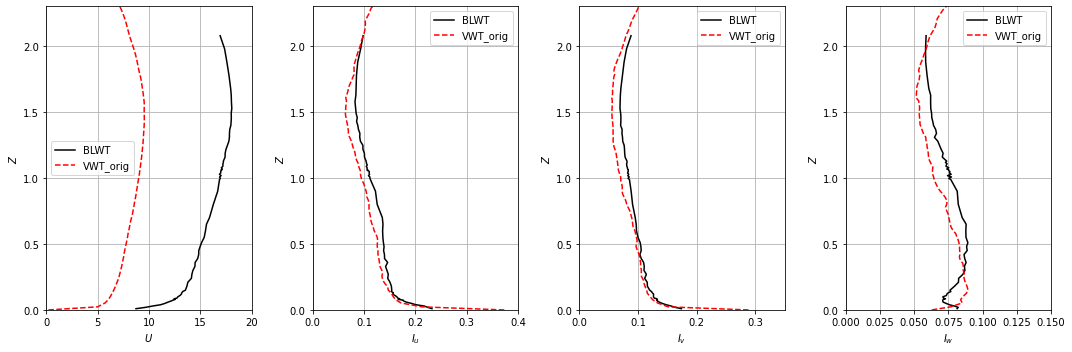

In [2]:
caseDir = "D:/tempData_depot/simData_CandC/tngE2/"
wtFile = caseDir+"tngE2Fr1_profile.csv"
vwtOrigFile = caseDir+"vwtO15orig.csv"

H = 0.08

target = wind.profile(name="BLWT",fileName=wtFile,Zref=H)
vwtOrig = wind.profile(name="VWT_orig",fileName=vwtOrigFile,Zref=H)

profs = wind.Profiles((target,vwtOrig))
profs.plotProfiles(
                    figSize=[15,5],
                    normalize=False,
                    xLimits=[[0,20],[0,0.4],[0,0.35],[0,0.15]],
                    zLimits=[0,2.3])



In [3]:
dt = 3.7890e-04

file = caseDir+"tngE2Fr1_TH-UofT.csv"
U_TH = np.transpose((pd.read_csv(file)).to_numpy())
file = caseDir+"tngE2Fr1_TH-VofT.csv"
V_TH = np.transpose((pd.read_csv(file)).to_numpy())
file = caseDir+"tngE2Fr1_TH-WofT.csv"
W_TH = np.transpose((pd.read_csv(file)).to_numpy())

# np.shape(U)


In [4]:
target = wind.profile(name="BLWT-E2", Z=target.Z,UofT=U_TH,VofT=V_TH,WofT=W_TH,Zref=H,dt=dt,nSpectAvg=64)

## Iteration 1

### Calibrate the scaling factors

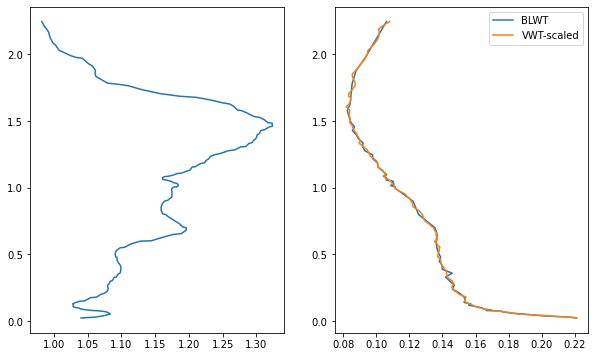

In [5]:
factorFile = caseDir+"tngE2_infScalingFactor_v0.csv"
Z = np.sort(np.concatenate((target.Z[2:],vwtOrig.Z[1:-10])))

intrp_U_wt = scintrp.interp1d(target.Z, target.U, fill_value='extrapolate')
intrp_Iu_wt = scintrp.interp1d(target.Z, target.Iu, fill_value='extrapolate')
intrp_Iv_wt = scintrp.interp1d(target.Z, target.Iv, fill_value='extrapolate')
intrp_Iw_wt = scintrp.interp1d(target.Z, target.Iw, fill_value='extrapolate')

intrp_U_vwt = scintrp.interp1d(vwtOrig.Z, vwtOrig.U, fill_value='extrapolate')
intrp_Iu_vwt = scintrp.interp1d(vwtOrig.Z, vwtOrig.Iu, fill_value='extrapolate')
intrp_Iv_vwt = scintrp.interp1d(vwtOrig.Z, vwtOrig.Iv, fill_value='extrapolate')
intrp_Iw_vwt = scintrp.interp1d(vwtOrig.Z, vwtOrig.Iw, fill_value='extrapolate')

fU_0 = smooth(np.divide(intrp_U_wt(Z), intrp_U_vwt(Z)),15,3)
fIu_0 = smooth(np.divide(intrp_Iu_wt(Z), intrp_Iu_vwt(Z)),15,3)
fIv_0 = smooth(np.divide(intrp_Iv_wt(Z), intrp_Iv_vwt(Z)),15,3)
fIw_0 = smooth(np.divide(intrp_Iw_wt(Z), intrp_Iw_vwt(Z)),15,3)

data = pd.DataFrame(np.stack((Z,fU_0,fIu_0,fIv_0,fIw_0),axis=-1),columns=["Z","U","Iu","Iv","Iw"])

# data.to_csv(factorFile,index=False)

plt.figure(figsize=[10,6])
plt.subplot(1,2,1)
plt.plot(fIu_0,Z)

plt.subplot(1,2,2)
plt.plot(intrp_Iu_wt(Z),Z,label="BLWT")
plt.plot(np.multiply(intrp_Iu_vwt(Z),fIu_0),Z,label="VWT-scaled")
plt.legend()
plt.show()

### Check scaled inflow data

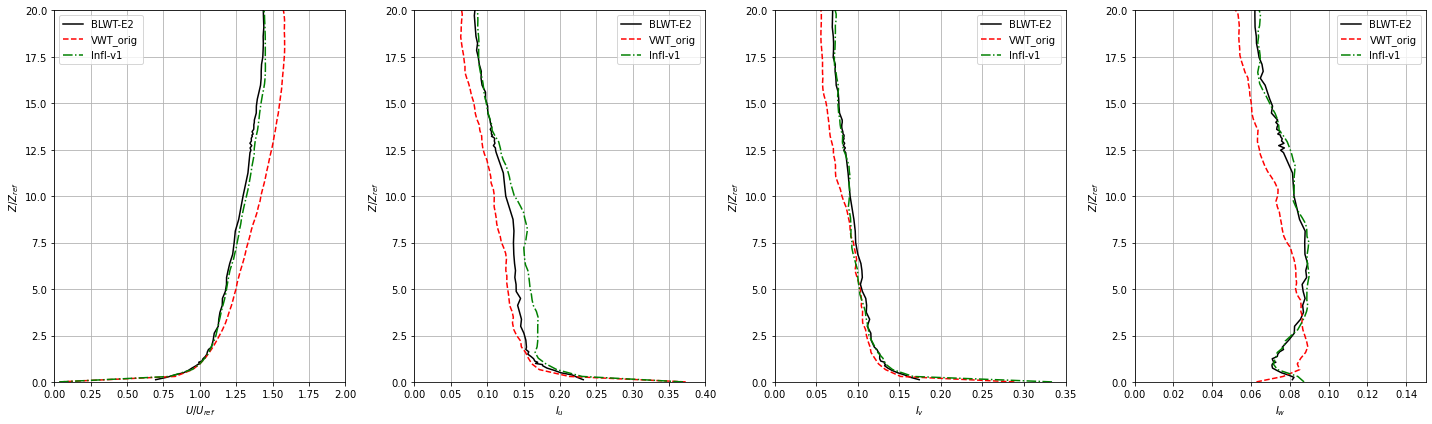

In [6]:
bData = "boundaryData_v1.0"
tRanges = ( ("0.0","5.0"),
            ("10.0","15.0"),
            ("30.0","35.0"),
            ("15.0","70.0"),
            ("64.0","65.0"),
            ("65.0","70.0"))
U = None
for t in tRanges:
    fileU = caseDir+"constant/"+bData+"/Scaled_"+t[0]+"_to_"+t[1]+"_U-TH.npy"
    fileV = caseDir+"constant/"+bData+"/Scaled_"+t[0]+"_to_"+t[1]+"_V-TH.npy"
    fileW = caseDir+"constant/"+bData+"/Scaled_"+t[0]+"_to_"+t[1]+"_W-TH.npy"
    if U is None:
        U = np.load(fileU)
        V = np.load(fileV)
        W = np.load(fileW)
    else:
        U = np.concatenate((U,np.load(fileU)),axis=1)
        V = np.concatenate((V,np.load(fileV)),axis=1)
        W = np.concatenate((W,np.load(fileW)),axis=1)

file = caseDir+"constant/"+bData+"/Scaled_"+tRanges[0][0]+"_to_"+tRanges[0][1]+"_profiles.csv"
prfl = pd.read_csv(file)

e = -1 #6500

scaled_v1 = wind.profile(name="Infl-v1", Z=prfl.Z,UofT=U[:,0:e],VofT=V[:,0:e],WofT=W[:,0:e],Zref=H,dt=0.001)

profs = wind.Profiles((target,vwtOrig,scaled_v1))

profs.plotProfiles(
                    figSize=[20,6],
                    normalize=True,
                    xLimits=[[0,2],[0,0.4],[0,0.35],[0,0.15]],
                    zLimits=[0,20])

# scaled_v1_0.plotTimeHistory(figSize=[20,3],xLimits=[0,8],xLabel='$t^*$',dataLabels=r'$x=\frac{ax^2}{2y^2}$',figFile=caseDir+"test.pdf",alwaysShowFig=True)


### Check empty domain simulation

In [7]:
emtyCD_CaseDir = "D:/tempData_depot/simData_CandC/tngE2empV0/"

file = emtyCD_CaseDir+"_processed/tngE2empV0__U-TH.npy"
U = np.load(file)
file = emtyCD_CaseDir+"_processed/tngE2empV0__V-TH.npy"
V = np.load(file)
file = emtyCD_CaseDir+"_processed/tngE2empV0__W-TH.npy"
W = np.load(file)

file = emtyCD_CaseDir+"_processed/tngE2empV0__profiles.csv"
prfl = pd.read_csv(file)

LES_E2v1 = wind.profile(name="LES-E2v1", Z=prfl.Z,UofT=U,VofT=V,WofT=W,Zref=H,dt=0.0002,nSpectAvg=32)

# profs = wind.Profiles((target,vwtOrig,scaled_v1,LES_E2v1))
profs = wind.Profiles((target,LES_E2v1))



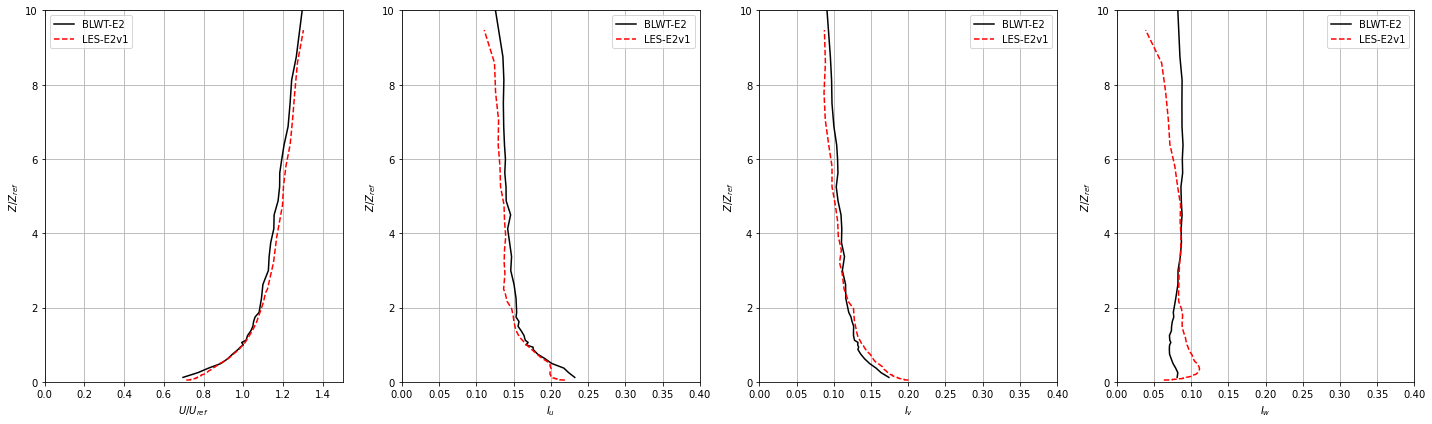

In [8]:
profs.plotProfiles(
                    figSize=[20,6],
                    normalize=True,
                    xLimits=[[0,1.5],[0,0.4],[0,0.4],[0,0.4]],
                    zLimits=[0,10])

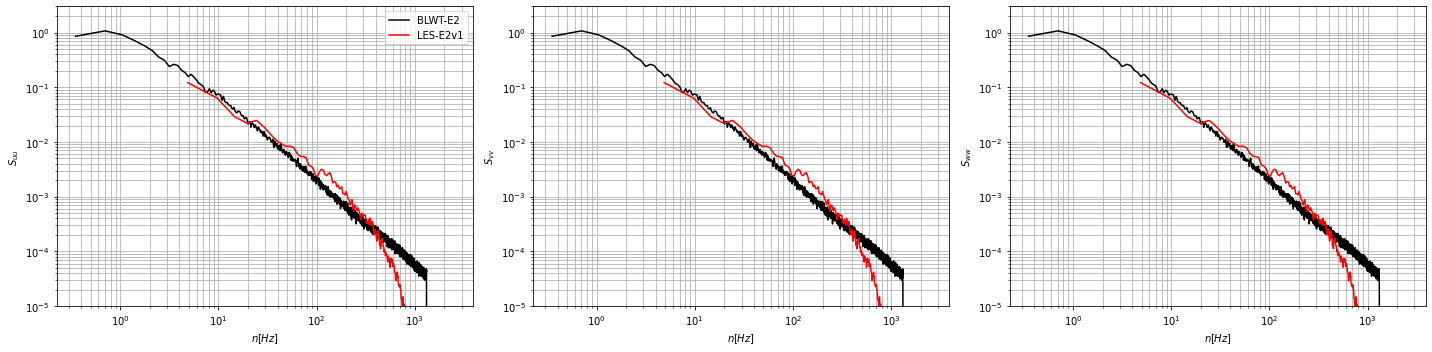

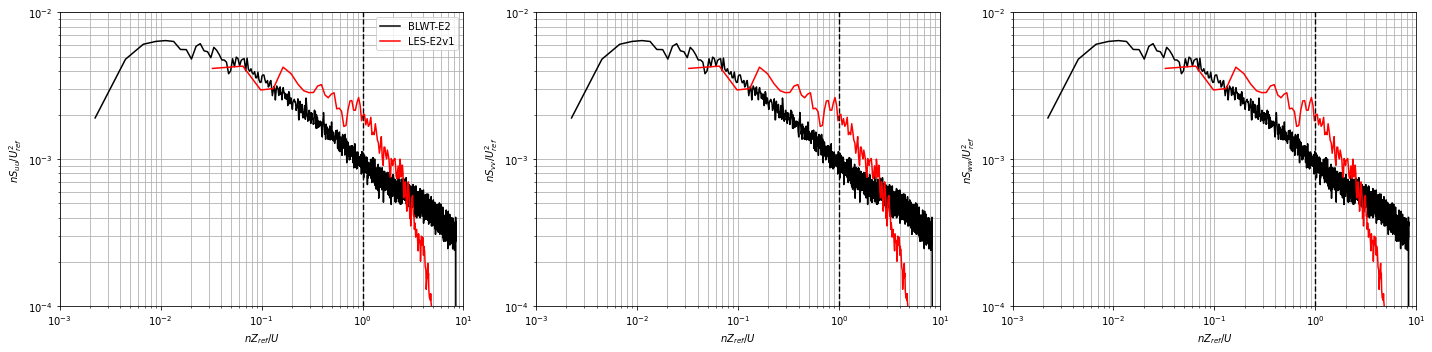

In [9]:
ylim = [1e-5,3e0]
profs.plotSpectra(figSize=[20,5],normalize=False,yLimits=(ylim,ylim,ylim))
ylim = [1e-4,1e-2] # ylim = [1e-4,0.01] #
profs.plotSpectra(figSize=[20,5],normalize=True,xLimits=[1e-3,1e1],yLimits=(ylim,ylim,ylim),plotType='loglog',normU='U')

# profs.plotTimeHistory(figSize=[15,6], yLimits=([0,25],[-10,10],[-10,10]),xLimits=[0,180])

# print(np.shape(LES_v1.UofT))
# print(np.shape(scaled_v1.UofT))

In [10]:
# from objexplore import explore
# import rich
# import scipy.io 

# data = scipy.io.loadmat('D:/OneDrive - The University of Western Ontario/Documents/PhD/Thesis/BLWT_tests/2022_08_TTU_WL_BLWT/Data/HFPI/tngE2p1_CpStats')

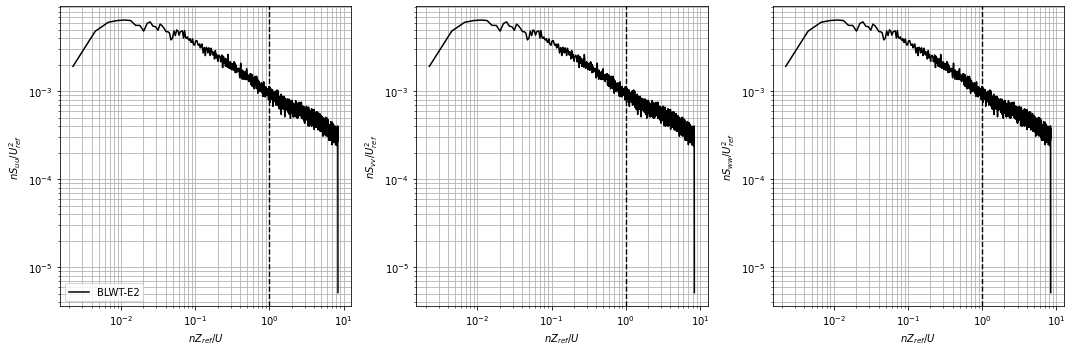

In [11]:
target.Spect_Zref.plotSpectra()

## Iteration 2

### Re-calibrate the scaling factors

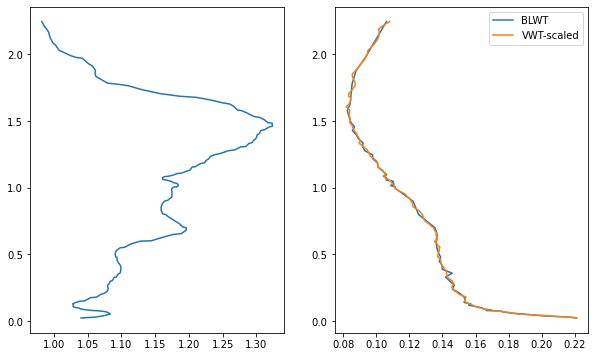

In [12]:
factorFile = caseDir+"tngE2_infScalingFactor_v1.csv"
Z = np.sort(np.concatenate((target.Z[2:],vwtOrig.Z[1:-10])))

intrp_U_wt = scintrp.interp1d(target.Z, target.U, fill_value='extrapolate')
intrp_Iu_wt = scintrp.interp1d(target.Z, target.Iu, fill_value='extrapolate')
intrp_Iv_wt = scintrp.interp1d(target.Z, target.Iv, fill_value='extrapolate')
intrp_Iw_wt = scintrp.interp1d(target.Z, target.Iw, fill_value='extrapolate')

intrp_U_vwt = scintrp.interp1d(vwtOrig.Z, vwtOrig.U, fill_value='extrapolate')
intrp_Iu_vwt = scintrp.interp1d(vwtOrig.Z, vwtOrig.Iu, fill_value='extrapolate')
intrp_Iv_vwt = scintrp.interp1d(vwtOrig.Z, vwtOrig.Iv, fill_value='extrapolate')
intrp_Iw_vwt = scintrp.interp1d(vwtOrig.Z, vwtOrig.Iw, fill_value='extrapolate')

fU_1 = smooth(np.divide(intrp_U_wt(Z), intrp_U_vwt(Z)),15,3)
fIu_1 = smooth(np.divide(intrp_Iu_wt(Z), intrp_Iu_vwt(Z)),15,3)
fIv_1 = smooth(np.divide(intrp_Iv_wt(Z), intrp_Iv_vwt(Z)),15,3)
fIw_1 = smooth(np.divide(intrp_Iw_wt(Z), intrp_Iw_vwt(Z)),15,3)

data = pd.DataFrame(np.stack((Z,fU_1,fIu_1,fIv_1,fIw_1),axis=-1),columns=["Z","U","Iu","Iv","Iw"])

# data.to_csv(factorFile,index=False)

plt.figure(figsize=[10,6])
plt.subplot(1,2,1)
plt.plot(fIu_1,Z)

plt.subplot(1,2,2)
plt.plot(intrp_Iu_wt(Z),Z,label="BLWT")
plt.plot(np.multiply(intrp_Iu_vwt(Z),fIu_1),Z,label="VWT-scaled")
plt.legend()
plt.show()